# EcoFOCIpy SBE16 QC

see [EcoFOCIpy_sbe_6627.ipynb](EcoFOCIpy_sbe_6627.ipynb) for initial processing and formatting.  Data would have been convertted from raw instrument format to csv files, initial dirty plots created and a meta-data rich and meta-data poor dataset would have been created.  The metadata poor csv file is used for the initial preliminary data archive, the metadata rich netcdf file is used for QC procedures and eventual final data archive.

## Next Steps

QC of data (plot parameters with other instruments)
- be sure to updated the qc_status and the history

- **TODO** Programmatically simplify following tools

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt
import yaml

import pandas as pd
import xarray as xr
import datetime
import ecofocipy.io.erddap as erddap

import ecofocipy.metaconfig.load_config as load_config

In [70]:
sample_data_dir = '/Users/bell/Programs/EcoFOCIpy/'
user_data_dir = '/Users/bell/ecoraid/2021/Moorings/21bsm2a/'

In [71]:
###############################################################
# edit to point to {instrument sepcific} raw datafile 
datafile = user_data_dir+'rawconverted/sbe16/21bsm2a_sbe16_6627_24.5m_rerun.cnv'
instrument = 'SBE-16 6627'
mooring_meta_file = user_data_dir+'logs/21BSM-2A.yaml'
inst_meta_file = sample_data_dir+'staticdata/instr_metaconfig/sbe16_cf.yaml'
institution_meta_file = sample_data_dir+'staticdata/institutional_meta_example.yaml' #include uaf?
inst_shortname = 's16'
###############################################################

In [72]:
#just a dictionary of dictionaries - simple
with open(mooring_meta_file) as file:
    mooring_config = yaml.full_load(file)

In [73]:
# this task only needed to be run once in the initial processing routine
# (sbe16_wop_nc.autotrim_time().to_dataframe()).to_csv(filename.replace('nc','csv')) #because the raw archived csv file doesn't trim out deck data, start with this file to edit 

#if it wasn't run, you can ingest the working netcdf file -> export it to csv as it should have been saved as a trimmed file, and work on that csv for manual edits
depth = str(int(mooring_config['Instrumentation'][instrument]['ActualDepth'])).zfill(4)
filename = "".join(mooring_config['MooringID'].split('-')).lower()+'_'+inst_shortname+'_'+str(depth).zfill(4)+'m.nc'
sbe16_wop_nc = xr.load_dataset(user_data_dir+'working/'+filename)
# sbe16_wop_nc.to_dataframe()).to_csv(filename.replace('nc','csv'))

In [74]:
url = "http://ecofoci-field.pmel.noaa.gov:8080/erddap"

erddap.test_erddap_connection(url=url) #basic test for connection to internal server, no response is a good thing

In [75]:
#grap deploy/recover cast data from erddap hosted sets - you have to know which profile you want though
depcast = erddap.erddapCTDretrieve(url=url,cruiseid='dy2103',qclevel='final',concastno='006')
# reccast = erddap.erddapCTDretrieve(url=url,cruiseid='dy2012',qclevel='preliminary',concastno='071')

#grab archived nrt instrument and a nearby instrument for this instance
moored_inst = erddap.erddapMooredInstretrieve(url=url,mooringid='21bsm2a',qclevel='preliminary',instrid=filename.split('.')[0])
moored_inst_47 = erddap.erddapMooredInstretrieve(url=url,mooringid='21bsm2a',qclevel='preliminary',instrid='21bsm2a_s56_0047m')
moored_inst_39 = erddap.erddapMooredInstretrieve(url=url,mooringid='21bsm2a',qclevel='preliminary',instrid='21bsm2a_s39_0039m')

In [76]:
moored_inst.sample()

,time (UTC),depth (m),latitude (degrees_north),longitude (degrees_east),temperature,salinity,timeseries_id
2218522,2022-01-25T14:00:00Z,24.5,56.87533,-164.07033,1.2002,31.9447,21bsm2a_s16_0024m


In [77]:
depcast.columns

Index(['pressure', 'chlor_fluorescence (ugrams/l)',
       'temperature_ch1 (degree_C)', 'temperature_ch2 (degree_C)', 'par',
       'turbidity (NTU)', 'temperature_rinko (degree_C)', 'voltage_rinko (V)',
       'salinity_ch1 (PSU)', 'salinity_ch2 (PSU)', 'sigma_t_ch1 (kg m-3)',
       'sigma_t_ch2 (kg m-3)', 'oxy_concM_ch1 (ml/l)',
       'oxy_conc_ch1 (micromole/kg)', 'oxy_percentsat_ch1 (percent)',
       'oxy_concM_ch2 (ml/l)', 'oxy_conc_ch2 (micromole/kg)',
       'oxy_percentsat_ch2 (percent)', 'latitude (degrees_north)',
       'longitude (degrees_east)', 'time (UTC)', 'chlor_fluorescence_QC',
       'temperature_ch1_QC', 'temperature_ch2_QC', 'par_QC', 'turbidity_QC',
       'temperature_rinko_QC', 'voltage_rinko_QC', 'salinity_ch1_QC',
       'salinity_ch2_QC', 'sigma_t_ch1_QC', 'sigma_t_ch2_QC',
       'oxy_concM_ch1_QC', 'oxy_conc_ch1_QC', 'oxy_percentsat_ch1_QC',
       'oxy_concM_ch2_QC', 'oxy_conc_ch2_QC', 'oxy_percentsat_ch2_QC',
       'Water_Depth (dbar)', 'air_pressur

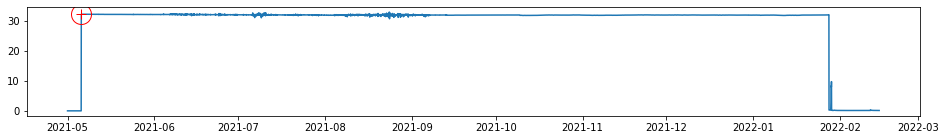

In [78]:
#plot ctd values with a small circular radius and zoom in on near their equivalent mooring time span, we are looking for visual discrepencies
#cycle through each depth and plot respective plot
depth = int(mooring_config['Instrumentation'][instrument]['ActualDepth'])

fig, ax = plt.subplots(1,figsize=(16, 2))
ax.plot(pd.to_datetime(moored_inst['time (UTC)']),moored_inst.salinity)
ax.plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time (UTC)']),
        depcast[depcast['pressure'] == depth]['salinity_ch1 (PSU)'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
ax.plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time (UTC)']),
        depcast[depcast['pressure'] == depth]['salinity_ch1 (PSU)'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='red')
# ax.plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time (UTC)']),
#         reccast[reccast['pressure'] == depth]['S_41 (PSU)'],
#         'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
# ax.plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time (UTC)']),
#         reccast[reccast['pressure'] == depth]['S_41 (PSU)'],
#         '+',markersize=10,markerfacecolor='none',markeredgecolor='red')

### QC Notes from plots

- **no pressure var - so assume pressure correction from other depths**
- rough field check points look good; no recovery ctd or mid deployment ctd though
- PAR seems to go erratic after November.  Drop all late deployment values

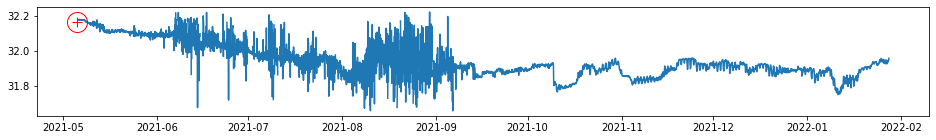

In [79]:
depth = int(mooring_config['Instrumentation'][instrument]['ActualDepth'])

fig, ax = plt.subplots(1,figsize=(16, 2))
ax.plot(sbe16_wop_nc.isel(latitude=0,longitude=0,depth=0).time,sbe16_wop_nc.isel(latitude=0,longitude=0,depth=0).salinity)
ax.plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time (UTC)']),
        depcast[depcast['pressure'] == depth]['salinity_ch1 (PSU)'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
ax.plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time (UTC)']),
        depcast[depcast['pressure'] == depth]['salinity_ch1 (PSU)'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='red')


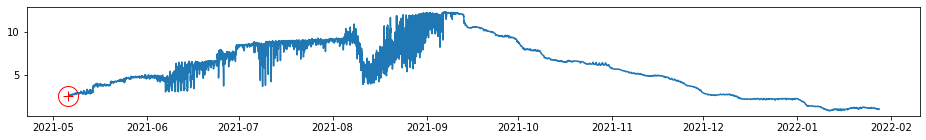

In [80]:
fig, ax = plt.subplots(1,figsize=(16, 2))
ax.plot(sbe16_wop_nc.isel(latitude=0,longitude=0,depth=0).time,sbe16_wop_nc.isel(latitude=0,longitude=0,depth=0).temperature)
ax.plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time (UTC)']),
        depcast[depcast['pressure'] == depth]['temperature_ch1 (degree_C)'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
ax.plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time (UTC)']),
        depcast[depcast['pressure'] == depth]['temperature_ch1 (degree_C)'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='red')


(18748.0, 18779.0)

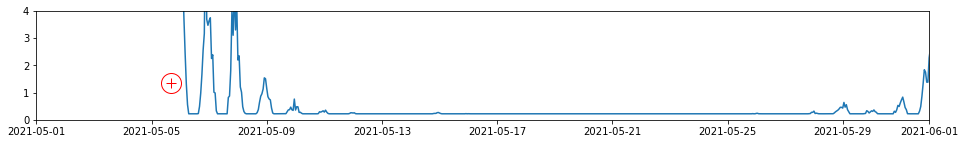

In [105]:
fig, ax = plt.subplots(1,figsize=(16, 2))
ax.plot(sbe16_wop_nc.isel(latitude=0,longitude=0,depth=0).time,sbe16_wop_nc.isel(latitude=0,longitude=0,depth=0).par)
ax.plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time (UTC)']),
        depcast[depcast['pressure'] == depth]['par'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
ax.plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time (UTC)']),
        depcast[depcast['pressure'] == depth]['par'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='red')
ax.set_ylim([0,4])
ax.set_xlim([datetime.date(2021,5,1),datetime.date(2021,6,1)])

### Filter and Remove Data

- add a 2-3 std filter on salinity, otherwise all looks ok
- odd par spikes in early January which are unreasonable

In [82]:
import ecofocipy.math.cleaning as cleaning #<- instrument specific
import ecofocipy.math.lanzcos as lanzcos #<- instrument specific
import numpy as np

In [83]:
var_choice = 'salinity'

STDcleaned_2 = cleaning.outlier_bounds_std(sbe16_wop_nc[var_choice],2.5)

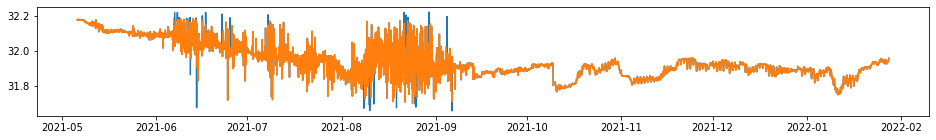

In [84]:
fig, ax = plt.subplots(1,figsize=(16, 2))
ax.plot(sbe16_wop_nc.isel(latitude=0,longitude=0,depth=0).time,sbe16_wop_nc.isel(latitude=0,longitude=0,depth=0).salinity)
ax.plot(sbe16_wop_nc.isel(latitude=0,longitude=0,depth=0).time,((sbe16_wop_nc.salinity* 0) + STDcleaned_2).isel(latitude=0,longitude=0,depth=0))


In [85]:
var_choice = 'par'

STDcleaned_2 = cleaning.outlier_bounds_std(sbe16_wop_nc[var_choice],2.5)

(0.0, 25.0)

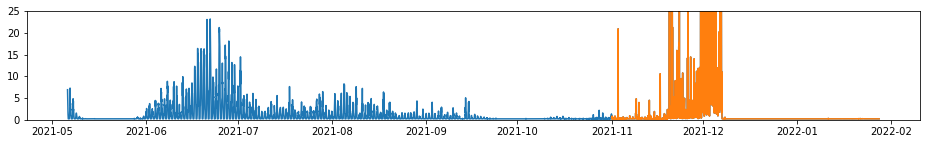

In [86]:
fig, ax = plt.subplots(1,figsize=(16, 2))
ax.plot(sbe16_wop_nc.isel(latitude=0,longitude=0,depth=0).time,sbe16_wop_nc.isel(latitude=0,longitude=0,depth=0).par)
ax.plot(sbe16_wop_nc.where((sbe16_wop_nc.time.dt.year >=2022) | (sbe16_wop_nc.time.dt.month >=11)).isel(latitude=0,longitude=0,depth=0).time,
        sbe16_wop_nc.where((sbe16_wop_nc.time.dt.year >=2022) | (sbe16_wop_nc.time.dt.month >=11))['par'].isel(latitude=0,longitude=0,depth=0))
ax.set_ylim([0,25])

In [87]:
sbe16_wop_nc_qc = sbe16_wop_nc.copy()

In [88]:
sbe16_wop_nc_qc['salinity'].values=((sbe16_wop_nc.salinity* 0) + STDcleaned_2)

In [89]:
sbe16_wop_nc_qc['par'] = sbe16_wop_nc.where((sbe16_wop_nc.time.dt.year >=2022) | (sbe16_wop_nc.time.dt.month >=11))['par']

### Update global attributes

In [90]:
sbe16_wop_nc_qc.attrs.update({'QC_indicator': 'ProbablyGood'})
sbe16_wop_nc_qc.attrs.update({'history':(sbe16_wop_nc_qc.history + "\nQCd: "+ str(datetime.datetime.today()))})

In [91]:
sbe16_wop_nc_qc.attrs.update({'date_modified':str(datetime.datetime.today())})

In [92]:
sbe16_wop_nc_qc.to_netcdf(user_data_dir+'working/'+filename,format="NETCDF3_CLASSIC",encoding={'time':{'units':'days since 1900-01-01'}})